### VOY A HACER LO MISMO QUE EN CLASE, DESPUES DE LAS TRANSFORMACIONES.


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Gradient Boosting
import xgboost as xgb

# Scikit-learn
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder

# Graphics
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geojson
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

from mpl_toolkits.basemap import Basemap
from matplotlib import cm
from descartes import PolygonPatch
from haversine import haversine

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import MiniBatchKMeans

%matplotlib inline

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Keras
import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
import keras.backend as K

# Scikit-learn
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler,MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split


# Graphics
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Using TensorFlow backend.


In [4]:
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_logarithmic_error(y_true, y_pred))

In [5]:
train = pd.read_csv('D:/BBDD/TAXI_NYC/train.csv')
test = pd.read_csv("D:/BBDD/TAXI_NYC/test.csv")

In [6]:
train['log_trip_duration'] = np.log(train['trip_duration'].values + 1)

In [7]:
y= train.log_trip_duration.values

In [8]:
id_train = train.id
id_test = test.id

train.drop(columns=['id'],inplace=True)
test.drop(columns=['id'],inplace=True)

In [9]:
print(train.shape)
print(test.shape)

(1458644, 11)
(625134, 8)


In [10]:
ntrain = train.shape[0]
ntest = test.shape[0]
y = train.log_trip_duration.values
all = pd.concat((train, test)).reset_index(drop=True)
all.drop(['log_trip_duration', 'trip_duration'], axis=1, inplace=True)
print("all size is : {}".format(all.shape))

all size is : (2083778, 9)


In [11]:
all.tail()


,dropoff_datetime,dropoff_latitude,dropoff_longitude,passenger_count,pickup_datetime,pickup_latitude,pickup_longitude,store_and_fwd_flag,vendor_id
2083773,NaN,40.733643,-74.001251,1,2016-01-01 00:02:52,40.725105,-74.003464,N,1
2083774,NaN,40.782467,-73.953407,1,2016-01-01 00:01:52,40.743782,-74.006363,N,1
2083775,NaN,40.748665,-73.876602,2,2016-01-01 00:01:24,40.759865,-73.972267,N,1
2083776,NaN,40.891788,-73.854263,1,2016-01-01 00:00:28,40.733562,-73.976501,N,1
2083777,NaN,40.769379,-73.969330,2,2016-01-01 00:00:22,40.716881,-73.981850,N,2


In [12]:
print(len(y))

1458644


In [13]:
all['pickup_datetime']  = pd.to_datetime(all['pickup_datetime'])
all['dropoff_datetime'] = pd.to_datetime(all['dropoff_datetime'])

In [14]:
hf = pd.read_csv("D:/BBDD/TAXI_NYC/NYC_2016Holidays.csv", sep=';')
hf['Date']  = pd.to_datetime(hf['Date'])

In [15]:
wf = pd.read_csv('D:/BBDD/TAXI_NYC/weather_NY_2016.csv')
wf['date']  = pd.to_datetime(wf['date'])

In [16]:
min_lat = all['pickup_latitude'].min()
max_lat = all['pickup_latitude'].max()
min_lon = all['pickup_longitude'].min()
max_lon = all['pickup_longitude'].max()

In [17]:
coords = np.vstack((all[['pickup_latitude',  'pickup_longitude']].values,
                    all[['dropoff_latitude', 'dropoff_longitude']].values,
                    all[['pickup_latitude',  'pickup_longitude']].values,
                    all[['dropoff_latitude', 'dropoff_longitude']].values))
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(coords)

In [18]:
def derive_features(all):
    all = all.copy()
    # Pickup-based features
    all['pickup_date'] = all['pickup_datetime'].dt.date
    all['pickup_weekday'] = all['pickup_datetime'].dt.weekday
    all['pickup_hour'] = all['pickup_datetime'].dt.hour
    all['pickup_month'] = all['pickup_datetime'].dt.month
    all['pickup_day'] = all['pickup_datetime'].dt.day
    # Brand new features
    all['haversine_distance'] = all.apply(lambda x: haversine((x['pickup_latitude'],  x['pickup_longitude']), 
                                                            (x['dropoff_latitude'], x['dropoff_longitude'])), axis=1)
    all['pickup_cluster']  = kmeans.predict(all[['pickup_latitude', 'pickup_longitude']])
    all['dropoff_cluster'] = kmeans.predict(all[['dropoff_latitude', 'dropoff_longitude']])
    return all

In [19]:
all = derive_features(all)

In [20]:
json_data = geojson.load(open('D:/BBDD/TAXI_NYC/community-districts-polygon.geojson'))
json_data.keys()
polygons = json_data['features']
FILL = '#6699cc'
CONT = '#1a169e'

In [21]:
def clean_data(all):
    all = all.copy()
    #all = all[(all['log_trip_duration'] > 60) & (all['log_trip_duration'] < 3600 * 24)] # Trip duration filtering
    all = all[(all['haversine_distance'] > 0.01)] # Distance filtering
    return all

In [22]:
all = clean_data(all)

In [23]:
wf = wf.replace(to_replace='T', value=0.01)

wf['precipitation'] = pd.to_numeric(wf['precipitation'])
wf['snow fall'] = pd.to_numeric(wf['snow fall'])
wf['snow depth'] = pd.to_numeric(wf['snow depth'])

In [24]:
all['pickup_date']   = pd.to_datetime(all['pickup_date'])
mf_train = all.merge(wf, left_on='pickup_date', right_on='date', how='inner')
#mf_train.tail()

In [25]:
all = mf_train

In [26]:
#all = all[all['trip_duration'] <  all['trip_duration'].quantile(0.999)]
#all = all[all['trip_duration'] <= all['trip_duration'].mean() + 3*all['trip_duration'].std()]
#print(' max time in min {:.2f} and mean time in sec {:.2f} '.format(
    #all['trip_duration'].max()/60, all['trip_duration'].mean()))

In [27]:
ep = 0.0001      
(lng1,lng2)=(-74.257*(1+ep), -73.699*(1-ep))
(lat1,lat2)=(40.495*(1+ep), 40.915*(1-ep)) 
all = all[(all['pickup_longitude'] <=lng2)&(all['pickup_longitude'] >=lng1)]
all = all[(all['pickup_latitude'] <=lat2) & (all['pickup_latitude'] >=lat1)]
all = all[(all['dropoff_longitude'] <=lng2)&(all['dropoff_longitude'] >=lng1)]
all = all[(all['dropoff_latitude'] <=lat2)&(all['dropoff_latitude'] >=lat1)]


In [28]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

In [29]:
#train['log_trip_duration'] = np.log(train['trip_duration'].values + 1)
all['pickup_datetime'] = pd.to_datetime(all.pickup_datetime)
all['Month'] = all['pickup_datetime'].dt.month
all['DayofMonth'] = all['pickup_datetime'].dt.day
all['Timehm'] = all['pickup_datetime'].dt.hour+all['pickup_datetime'].dt.minute/60
all['dayofweek'] = all['pickup_datetime'].dt.dayofweek

holidays = calendar().holidays(start='2015-12-31', end='2016-07-01')
all['Holiday']=all['pickup_datetime'].dt.date.astype('datetime64[ns]').isin(holidays).astype(int)
all.drop(['dropoff_datetime','pickup_datetime'], axis=1,inplace=True)
all['store_and_fwd_flag'] = all['store_and_fwd_flag'].map({'N': 0, 'Y':1}).astype(int)
all.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2069818 entries, 0 to 2071359
Data columns (total 27 columns):
dropoff_latitude       float64
dropoff_longitude      float64
passenger_count        int64
pickup_latitude        float64
pickup_longitude       float64
store_and_fwd_flag     int32
vendor_id              int64
pickup_date            datetime64[ns]
pickup_weekday         int64
pickup_hour            int64
pickup_month           int64
pickup_day             int64
haversine_distance     float64
pickup_cluster         int32
dropoff_cluster        int32
date                   datetime64[ns]
maximum temperature    int64
minimum temperature    int64
average temperature    float64
precipitation          float64
snow fall              float64
snow depth             float64
Month                  int64
DayofMonth             int64
Timehm                 float64
dayofweek              int64
Holiday                int32
dtypes: datetime64[ns](2), float64(10), int32(4), int64(11)
memory

In [30]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    d = np.sin(lat2/2-lat1/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng2/2-lng1/2)**2
    return 2 * 6371 * np.arcsin(np.sqrt(d))

In [31]:
#def haversine_array(lat1, lng1, lat2, lng2):
    #lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    #d = np.sin(lat2/2-lat1/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng2/2-lng1/2)**2
    #return 2 * 6371 * np.arcsin(np.sqrt(d))

In [32]:
def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    return haversine_array(lat1,lng1,lat1,lng2)+haversine_array(lat1,lng1,lat2,lng1)

In [33]:
def bearing_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng2 - lng1) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng2 - lng1)
    return np.degrees(np.arctan2(y, x))

In [34]:
all['distance_haversine'] = haversine_array(all['pickup_latitude'].values, all['pickup_longitude'].values, 
                                          all['dropoff_latitude'].values, all['dropoff_longitude'].values)

all['distance_dummy_manhattan'] =  dummy_manhattan_distance(all['pickup_latitude'].values, 
            all['pickup_longitude'].values, all['dropoff_latitude'].values, all['dropoff_longitude'].values)

all['direction'] = bearing_array(all['pickup_latitude'].values, all['pickup_longitude'].values, 
                                      all['dropoff_latitude'].values, all['dropoff_longitude'].values)
all.shape

(2069818, 30)

In [35]:
coords = np.vstack((all[['pickup_latitude', 'pickup_longitude']].values,
                    all[['dropoff_latitude', 'dropoff_longitude']].values))
sample_ind = np.random.permutation(len(coords))[:1000000]
kmeans = MiniBatchKMeans(n_clusters=9**2, batch_size=36**3).fit(coords[sample_ind])
all['pickup_cluster'] = kmeans.predict(all[['pickup_latitude', 'pickup_longitude']])
all['dropoff_cluster'] = kmeans.predict(all[['dropoff_latitude', 'dropoff_longitude']])
all.shape

(2069818, 30)

In [36]:
from sklearn.decomposition import PCA

In [37]:
pca = PCA().fit(coords)
all['pickup_pca0'] = pca.transform(all[['pickup_latitude', 'pickup_longitude']])[:, 0]
all['pickup_pca1'] = pca.transform(all[['pickup_latitude', 'pickup_longitude']])[:, 1]
all['dropoff_pca0'] = pca.transform(all[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
all['dropoff_pca1'] = pca.transform(all[['dropoff_latitude', 'dropoff_longitude']])[:, 1]
all['pca_manhattan'] = np.abs(all['dropoff_pca1']-all['pickup_pca1']) +  np.abs(
                                 all['dropoff_pca0']-all['pickup_pca0'])
all['center_latitude'] = 0.5*all['pickup_latitude']+0.5*all['dropoff_latitude']
all['center_longitude'] = 0.5*all['pickup_longitude']+0.5*all['dropoff_longitude']
#del coords, sample_ind, kmeans
all.shape

(2069818, 37)

In [38]:
flag=False
if flag:
    cols=['id', 'total_distance', 'total_travel_time',  'number_of_steps']
    fr1 = pd.read_csv(myfolder+'fastest_routes_train_part_1.csv', usecols=cols)
    fr2 = pd.read_csv(myfolder+'fastest_routes_train_part_2.csv', usecols=cols)
    fr3 = pd.read_csv(myfolder+'fastest_routes_test.csv', usecols=cols)
    tmp = pd.concat((fr1, fr2, fr3))
    tmp.columns=['id', 'OSRM_distance', 'OSRM_time',  'OSRM_steps']
    Data = Data.merge(tmp, how='left', on='id')
    del fr1, fr2, fr3, tmp
    gc.collect()
    Data.shape
print(flag)  

False


In [39]:
train = all[:ntrain]
test = all[ntrain:]

In [40]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1458644 entries, 0 to 1459739
Data columns (total 37 columns):
dropoff_latitude            1458644 non-null float64
dropoff_longitude           1458644 non-null float64
passenger_count             1458644 non-null int64
pickup_latitude             1458644 non-null float64
pickup_longitude            1458644 non-null float64
store_and_fwd_flag          1458644 non-null int32
vendor_id                   1458644 non-null int64
pickup_date                 1458644 non-null datetime64[ns]
pickup_weekday              1458644 non-null int64
pickup_hour                 1458644 non-null int64
pickup_month                1458644 non-null int64
pickup_day                  1458644 non-null int64
haversine_distance          1458644 non-null float64
pickup_cluster              1458644 non-null int32
dropoff_cluster             1458644 non-null int32
date                        1458644 non-null datetime64[ns]
maximum temperature         1458644 non-nul

In [41]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 611174 entries, 1459740 to 2071359
Data columns (total 37 columns):
dropoff_latitude            611174 non-null float64
dropoff_longitude           611174 non-null float64
passenger_count             611174 non-null int64
pickup_latitude             611174 non-null float64
pickup_longitude            611174 non-null float64
store_and_fwd_flag          611174 non-null int32
vendor_id                   611174 non-null int64
pickup_date                 611174 non-null datetime64[ns]
pickup_weekday              611174 non-null int64
pickup_hour                 611174 non-null int64
pickup_month                611174 non-null int64
pickup_day                  611174 non-null int64
haversine_distance          611174 non-null float64
pickup_cluster              611174 non-null int32
dropoff_cluster             611174 non-null int32
date                        611174 non-null datetime64[ns]
maximum temperature         611174 non-null int64
mini

In [42]:
train.drop(['pickup_date', 'date'], axis=1, inplace=True)
test.drop(['pickup_date', 'date'],axis=1, inplace=True )

In [43]:
np.sum(train.isna())

dropoff_latitude            0
dropoff_longitude           0
passenger_count             0
pickup_latitude             0
pickup_longitude            0
store_and_fwd_flag          0
vendor_id                   0
pickup_weekday              0
pickup_hour                 0
pickup_month                0
pickup_day                  0
haversine_distance          0
pickup_cluster              0
dropoff_cluster             0
maximum temperature         0
minimum temperature         0
average temperature         0
precipitation               0
snow fall                   0
snow depth                  0
Month                       0
DayofMonth                  0
Timehm                      0
dayofweek                   0
Holiday                     0
distance_haversine          0
distance_dummy_manhattan    0
direction                   0
pickup_pca0                 0
pickup_pca1                 0
dropoff_pca0                0
dropoff_pca1                0
pca_manhattan               0
center_lat

In [44]:
np.sum(test.isna())

dropoff_latitude            0
dropoff_longitude           0
passenger_count             0
pickup_latitude             0
pickup_longitude            0
store_and_fwd_flag          0
vendor_id                   0
pickup_weekday              0
pickup_hour                 0
pickup_month                0
pickup_day                  0
haversine_distance          0
pickup_cluster              0
dropoff_cluster             0
maximum temperature         0
minimum temperature         0
average temperature         0
precipitation               0
snow fall                   0
snow depth                  0
Month                       0
DayofMonth                  0
Timehm                      0
dayofweek                   0
Holiday                     0
distance_haversine          0
distance_dummy_manhattan    0
direction                   0
pickup_pca0                 0
pickup_pca1                 0
dropoff_pca0                0
dropoff_pca1                0
pca_manhattan               0
center_lat

In [45]:
x_train, x_val, y_train, y_val = train_test_split(train.values,y,test_size=0.2, random_state=2019)
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(1166915, 35)
(1166915,)
(291729, 35)
(291729,)


In [46]:
x_test = test.values
print(x_train.shape)

(1166915, 35)


In [47]:
scaler =  StandardScaler() #MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

In [98]:
INPUT_SHAPE = x_train.shape[1]

# Model
model = Sequential()
model.add(Dense(2048, input_shape=(INPUT_SHAPE,), kernel_initializer='normal', activation='relu'))
model.add(Dense(1024, kernel_initializer='normal', activation='relu'))
model.add(Dense(512, kernel_initializer='normal', activation='relu'))
model.add(Dense(256, kernel_initializer='normal', activation='relu'))
model.add(Dense(128, kernel_initializer='normal', activation='relu'))
model.add(Dense(64, kernel_initializer='normal', activation='relu'))
model.add(Dense(32, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))

# Compile model
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

model.compile(loss=root_mean_squared_error, optimizer='rmsprop')


In [99]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_93 (Dense)             (None, 2048)              73728     
_________________________________________________________________
dense_94 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dense_95 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_96 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_97 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_98 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_99 (Dense)             (None, 32)                2080      
__________

In [108]:
history = model.fit(x_train, y_train,
          batch_size=2048,
          epochs=100,
          validation_data = (x_val, y_val),
          callbacks = [EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True)])


Train on 1166915 samples, validate on 291729 samples
Epoch 1/100
1166915/1166915 [==============================] - 183s 157us/step - loss: 0.7467 - val_loss: 0.7049
Epoch 2/100
1166915/1166915 [==============================] - 182s 156us/step - loss: 0.7260 - val_loss: 0.7092
Epoch 3/100
1166915/1166915 [==============================] - 183s 157us/step - loss: 0.7113 - val_loss: 0.7033
Epoch 4/100
1166915/1166915 [==============================] - 181s 155us/step - loss: nan - val_loss: nan
Epoch 5/100
1166915/1166915 [==============================] - 182s 156us/step - loss: nan - val_loss: nan
Epoch 6/100
1166915/1166915 [==============================] - 183s 157us/step - loss: nan - val_loss: nan


<Figure size 432x288 with 0 Axes>

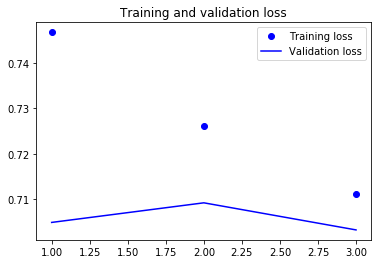

<Figure size 432x288 with 0 Axes>

In [109]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()

In [110]:
ypred = model.predict(x_test)

In [111]:
pred = np.exp(ypred)-1

In [112]:
pred

array([[ 931.7851],
       [1029.767 ],
       [ 859.9432],
       ...,
       [1121.5176],
       [1123.2006],
       [ 805.3899]], dtype=float32)

#########################################################################################################################